In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

# !pip install deap

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

import operator
import random

import math

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.9 MB/s eta 0:00:00


In [2]:
# The dataset comes in data of the range 0-1, we want to convert this to -1 to 1 as part of normalisation

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Function to transform the dataset to the specified range

batch_size = 512

# Downloading the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Loading the training set into a variable
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# etc.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Specifying the classes of the dataset that we want to train the classifier on
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 43014908.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
totalImages = len(trainloader.dataset)
print(totalImages)

# How many trainloaders we want to create, each with the miniAmount of images in it
miniAmount = 1000

numOfLoaders = totalImages // miniAmount

print("Number of loaders to create: " + str(numOfLoaders)) # 10 Loaders

# Contains the list of trainloaders
miniLoaders = []

for i in range(numOfLoaders):
  startIdx = i * miniAmount
  endIdx = (i + 1) * miniAmount if i < numOfLoaders - 1 else totalImages

  print("Start Index: " + str(startIdx))
  print("End Index: " + str(endIdx) + "\n")

  # Creates a subset of the whole training set
  subset = torch.utils.data.Subset(trainset, range(startIdx, endIdx))

  SubTrainLoader = torch.utils.data.DataLoader(subset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

  miniLoaders.append(SubTrainLoader)

50000
Number of loaders to create: 50
Start Index: 0
End Index: 1000

Start Index: 1000
End Index: 2000

Start Index: 2000
End Index: 3000

Start Index: 3000
End Index: 4000

Start Index: 4000
End Index: 5000

Start Index: 5000
End Index: 6000

Start Index: 6000
End Index: 7000

Start Index: 7000
End Index: 8000

Start Index: 8000
End Index: 9000

Start Index: 9000
End Index: 10000

Start Index: 10000
End Index: 11000

Start Index: 11000
End Index: 12000

Start Index: 12000
End Index: 13000

Start Index: 13000
End Index: 14000

Start Index: 14000
End Index: 15000

Start Index: 15000
End Index: 16000

Start Index: 16000
End Index: 17000

Start Index: 17000
End Index: 18000

Start Index: 18000
End Index: 19000

Start Index: 19000
End Index: 20000

Start Index: 20000
End Index: 21000

Start Index: 21000
End Index: 22000

Start Index: 22000
End Index: 23000

Start Index: 23000
End Index: 24000

Start Index: 24000
End Index: 25000

Start Index: 25000
End Index: 26000

Start Index: 26000
End

In [4]:
# Testing to see how miniLoaders look

print(len(miniLoaders))

print(miniLoaders[9])

print(trainloader)

# with 5000 images in each loader, we have 10 loaders in total, need to loop back to beginning after miniLoader[9]

50


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


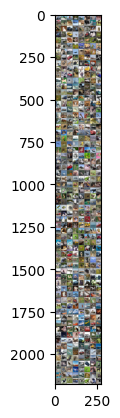

car   bird  ship  ship  ship  horse ship  dog   horse bird  horse plane deer  dog   dog   horse bird  cat   truck bird  frog  dog   deer  cat   plane bird  car   bird  cat   truck dog   frog  deer  ship  frog  dog   deer  horse frog  horse truck ship  plane deer  ship  truck bird  plane car   horse ship  plane ship  frog  bird  ship  frog  car   car   bird  deer  horse ship  plane horse dog   cat   deer  cat   car   car   deer  dog   dog   car   truck plane truck truck cat   plane ship  car   frog  cat   cat   frog  ship  ship  dog   plane ship  bird  car   dog   cat   car   horse ship  plane truck frog  ship  deer  frog  bird  plane frog  frog  frog  horse car   deer  truck car   truck horse deer  deer  plane plane dog   bird  cat   truck deer  truck truck horse ship  plane plane truck truck deer  deer  dog   frog  ship  cat   bird  horse truck plane car   horse plane dog   car   horse frog  car   horse bird  car   deer  dog   cat   ship  bird  ship  dog   deer  cat   plane plane car 

In [6]:
# functions to show an image for fun

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images from the first DataLoader
dataiter = iter(miniLoaders[1])
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
#based on VGG
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 52),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(52, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model=Net()

In [9]:
PATH = ('./40_epoch_32_batch_SGD_net.pth')
PopModel = Net()
PopModel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
# Setting all layers to not change their weights with GD backpropagation

for param in PopModel.parameters():
    # By setting the requires grad for each parameter to false, we no longer track it with autograd
    # Consequently, backpropagation or whatever will not compute the gradients for these layers
    param.requires_grad = False

In [11]:
finalLayer = PopModel.classifier[-1]

print(finalLayer) # 10 features out

outerShape = len(finalLayer.weight)
innerShape = len(finalLayer.weight[0])

totalWeights = outerShape * innerShape

print(outerShape) # 10 population size
print(innerShape) # 10 arrays, with 52 items in it

# 52 inputs connected to a single output, there are 10 outputs therefore 52x10 connections in total. for one output, the 52 connections will have 52 different weights which are used
# to calculate the output node. therefore there are 10 tensors with 52 elements in each tensor, with a different set of weights.

biasCount = len(finalLayer.bias)
print(biasCount)

paramCount = sum(param.numel() for param in finalLayer.parameters())

print(paramCount) # 530 Parameters: 520 weights + 10 biases


Linear(in_features=52, out_features=10, bias=True)
10
52
10
530


In [12]:
# Randomise final layer weights

nn.init.xavier_uniform(finalLayer.weight)

print((finalLayer.weight).shape) # Shape that the layer requires is (10,52)

print((finalLayer.bias).shape)

torch.Size([10, 52])
torch.Size([10])


<ipython-input-12-6e0b5b33f1e0>:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(finalLayer.weight)


In [13]:
# Additional Function for converting weights to a numpy array

def convert_np_function(self, intermediate_tensor):
        intermediate_value = intermediate_tensor.numpy()
        self.intermediate_values.append(intermediate_value)

populationList = finalLayer.weight.numpy()

#SSPSO

In [14]:
posMinInit      = -0.1
posMaxInit      = +0.1
VMaxInit        = 1.5
VMinInit        = 0.5
# populationSize  = 3
dimension       = paramCount
populationSize  = 100+int(dimension/10) # from lab on SL-PSO
#interval        = 10
interval = 1
iterations      = 100

#variables used in SL-PSO
epsilon = dimension/100.0*0.01 # social influence of swarm centre

# Criterion for measuring loss, may need to tweak this to return negative value for PSO
criterion = nn.CrossEntropyLoss()

lossTracker = []

accuracyTracker = []

In [15]:
# function to get the mean positions of the inviduals (swarm centre)
def getcenter(pop):
    center=list()
    for j in range(dimension): # count through dimensions
        centerj = 0
        for i in pop: # for each particle
            centerj += i[j] # sum up position in dimention j
        centerj /= populationSize # Average
        center.append(centerj)
    return center

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin=None, smax=None, best=None)

In [16]:
# particle rerpresented by list of 5 things
# 1. fitness of the particle,
# 2. speed of the particle which is also going to be a list,
# 3.4. limit of the speed value,
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(random.uniform(posMinInit, posMaxInit) for _ in range(size))
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part

def updateParticle(part,pop,center,i):
    r1 = random.uniform(0, 1)
    r2 = random.uniform(0, 1)
    r3 = random.uniform(0, 1)

    #Randomly choose a demonstrator for particle i from any of particles 0 to i-1, the Particle i
    #updates its velocity by learning from the demonstrator and the mean position of the swarm
    demonstrator=random.choice(list(pop[0:i]))

    for j in range(dimension): # count through dimensions
        part.speed[j]=r1*part.speed[j]+r2*(demonstrator[j]-part[j])+r3*epsilon*(center[j]-part[j])
        part[j]=part[j]+part.speed[j]

def getBestAccuracy(bestParticle):
  bestNP = np.array(bestParticle)

  # Splitting into weights and biases
  bestWeights = bestNP[:totalWeights]
  bestBiases = bestNP[-biasCount:]

  # Putting biases in
  bestBiases = torch.from_numpy(bestBiases).float()
  finalLayer.bias = torch.nn.Parameter(bestBiases.float())

  # Reshaping weights so they are correct for the layer
  bestWeights = bestWeights.reshape(outerShape,innerShape)

  # Converting to torch array
  bestWeights = torch.from_numpy(bestWeights).float()

  # Putting the weights into the layer
  finalLayer.weight = torch.nn.Parameter(bestWeights.float())

  correct_pred = 0
  total_pred = 0

  PopModel.to(device)

  for data in trainloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = PopModel(images)

  _, predictions = torch.max(outputs, 1)

  # collect the correct predictions for each class

  for label, prediction in zip(labels, predictions):
    if label == prediction:
      correct_pred += 1
    total_pred += 1

  acc = (correct_pred / total_pred)*100


  print("Accuracy of current best particle: " + str(acc) + "%")

  return acc

In [17]:
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)

# Note most likely need to change the evaluate function
toolbox.register("evaluate", benchmarks.sphere) #sphere function is built-in in DEAP

runCounter = 0

def modelEval(particle, runCounter, miniNumber):
    runCounter = runCounter
    runCounter +=1

    #print("Mini Number: " + str(miniNumber))

    # First step to get the particles weights out from it, convert to an numpy array
    particleweightsNP1 = np.array(particle)

    #particleweightsNP = particleweightsNP1[:840]
    #biases = np.array(particleweightsNP1[-10:])
    particleweightsNP = particleweightsNP1[:totalWeights]
    biases = np.array(particleweightsNP1[-biasCount:])

    # Putting biases straight in
    biases = torch.from_numpy(biases).float()
    finalLayer.bias = torch.nn.Parameter(biases.float())

    #print(particleweightsNP)

#     print("Shape of particle: " + str(particleweightsNP.shape))

    # Converting to the correct shape!
    reshapedWeights = particleweightsNP.reshape(outerShape,innerShape)
#     print("Shape of reshaped particle: " + str(reshapedWeights.shape))

    # Convert to torch array!
    torchWeights = torch.from_numpy(reshapedWeights).float()

    # Now we want to set the weights of the finalLayer to these weights

    finalLayer.weight = torch.nn.Parameter(torchWeights.float())

    # print("After:\n")
    # print(finalLayer.weight)

    #finalLayer.weight.data = torchWeights.float()
    #print(finalLayer.weight) # Note that the numbers look different than torchWeights ?
    #print(torchWeights)

    # Run a training loop for the model, with the particles weights set to the final layer and return a loss value back

    epoch_loss = 0.0
    running_loss = 0.0

    # reshapedWeights.to(device)
    # torchWeights.to(device)

#     print(f"Starting training run {runCounter}...")

    PopModel.to(device)

    for epoch in range(1):

        epoch_loss = 0.0

        for i, data in enumerate(miniLoaders[miniNumber], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # Getting the predictions for the model
            outputs = PopModel(inputs)

            loss = criterion(outputs, labels)

            #print(loss.item())

            epoch_loss += loss.item()

#         print("End of Epoch:" + str(epoch))

        running_loss += (epoch_loss / i)

    # Now we have a loss value:
    #print("Total Loss: " + str(running_loss))

    return running_loss,

toolbox.register("evaluate2", modelEval)

In [18]:
def main():
    pop = toolbox.population(n=populationSize) # Population Size
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    #intialize the learning probabilities
    prob=[0]*populationSize
    for i  in range(len(pop)):
        prob[populationSize - i - 1] = 1 - i/(populationSize - 1)
        prob[populationSize - i - 1] = pow(prob[populationSize - i - 1], math.log(math.sqrt(math.ceil(dimension/100.0))))

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    miniCounter = 0

    #begin main loop
    for g in range(iterations):

        for part in pop:
            part.fitness.values = toolbox.evaluate2(part, runCounter, miniCounter) #actually only one fitness value

        #Sort the individuals in the swarm in ascending order. i.e., particle 0 is the best

        # sortedPop = pop

        pop.sort(key=lambda x: x.fitness, reverse=True)
        #calculate the center (mean value) of the swarm
        center = getcenter(pop)

        # Code to update particle via velocity
        for i  in reversed(range(len(pop)-1)):  # start with worst particle, and go in reverse towards best
                                                # don't do element 0 (best). Hence the i+1 below.
            if random.uniform(0, 1)<prob[i+1]: #learning probability for that particle
                toolbox.update(pop[i+1],pop,center,i+1)

        # Gather all the fitnesses in one list and print the stats
        # print every interval
        if g%interval==0: # interval
            logbookRecord = logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
            print(logbook.stream)

        avgloss = logbook.select("avg")[-1]

        # Add the average loss to the list, may not be necessary but it is useful
        lossTracker.append(avgloss)

        # Evaluate the accuracy of the current best particle

        accuracyTracker.append(getBestAccuracy(pop[0]))

        miniCounter += 1

        if miniCounter >= (len(miniLoaders)):
          miniCounter = 0
          print("Mini Counter reset!")

    return pop, logbook

if __name__ == "__main__":
    superpart = main()

gen	evals	avg    	std     	min    	max    
0  	153  	5.29321	0.292519	4.53615	6.19623
Accuracy of current best particle: 18.75%
Current Mutation Tick: 1
1  	153  	6.76915	2.47004 	4.61916	14.7047
Accuracy of current best particle: 21.428571428571427%
Current Mutation Tick: 0
2  	153  	7.28336	3.36283 	4.57702	21.9529
Accuracy of current best particle: 18.452380952380953%
Current Mutation Tick: 0
3  	153  	6.94962	3.02744 	4.50119	24.5949
Accuracy of current best particle: 13.095238095238097%
Current Mutation Tick: 0
4  	153  	6.6839 	2.55356 	4.56236	20.0022
Accuracy of current best particle: 17.261904761904763%
Current Mutation Tick: 0
5  	153  	6.4032 	2.47099 	4.49096	19.7133
Accuracy of current best particle: 12.797619047619047%
Current Mutation Tick: 0
6  	153  	6.05137	2.07376 	4.52347	17.7755
Accuracy of current best particle: 19.940476190476193%
Current Mutation Tick: 0
7  	153  	5.96862	2.02374 	4.37789	15.4159
Accuracy of current best particle: 17.857142857142858%
Current Mut

KeyboardInterrupt: ignored

In [ ]:
# Quicksave the best particle

print(len(superpart[1])) # best particle has 840 weights in it
print(superpart[1])
arr = np.array(superpart[1])

print(arr.shape)

import csv

with open('superpart.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([superpart[0][0]])

with open('logbook.csv', 'a', newline='') as file:
    writer = csv.writer(file)
#     writer.writerows(["gen","evals","avg","std","min","max"])
    writer.writerows([superpart[1].select("gen"),superpart[1].select("evals"),superpart[1].select("avg"),
                      superpart[1].select("std"),superpart[1].select("min"),superpart[1].select("max")])

In [ ]:
# Write accuracy data to csv

with open('accuracyTrack.csv', 'a', newline='') as file:
    newWriter = csv.writer(file)
    newWriter.writerows([accuracyTracker])

In [ ]:
# Put in the bestparticle like this superPart[2] (format to get the best particle after running main)
def evaluateBest(bestParticle):
  bestNP = np.array(bestParticle)

  # Splitting into weights and biases

  bestWeights = bestNP[:totalWeights]
  bestBiases = bestNP[-biasCount:]

  # Putting biases in
  bestBiases = torch.from_numpy(bestBiases).float()
  finalLayer.bias = torch.nn.Parameter(bestBiases.float())

  # Reshaping weights so they are correct for the layer
  bestWeights = bestWeights.reshape(outerShape,innerShape)

  # Converting to torch array
  bestWeights = torch.from_numpy(bestWeights).float()

  # Putting the weights into the layer

  finalLayer.weight = torch.nn.Parameter(bestWeights.float())


  # Evaluating the best particle on the test set

  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  correct = 0
  total = 0

  # Move the model onto GPU again? Most likely do not need to as it should already be in the GPU


  PopModel.to(device)

  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = PopModel(images)

    _, predictions = torch.max(outputs, 1)

    # collect the correct predictions for each class


    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
            correct += 1
        total_pred[classes[label]] += 1
        total += 1

  # Printing the results
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    raccuracy = (correct/total)*100
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


    return raccuracy

In [ ]:
accFinal = evaluateBest(superpart[0][0])

In [ ]:
print(accFinal)

In [ ]:
f = open("accFinal.txt", "a")
f.write(str(accFinal))
f.close()